**Name:** Karlis Siders

**Student Number:** 2467273

# Text As Data Coursework

Please fill in this Google Colab by following the prompts from the coursework specification document and inserting your code in each relevant section.

- You should submit this notebook together with your report. (Two separate files)
- Specifcally you will submit **both a PDF with the report (so we can easily read it) and a .ipynb file containing the source code of your experiments as evidence**. Please do clean up your code where possible before submitting it.
- You may add whatever additional code and text blocks as needed (perhaps with [nice formatting](https://colab.research.google.com/notebooks/markdown_guide.ipynb)). Please keep the major headings (for the question numbers) the same.

As with labs, please remember to **Save a Copy to Drive** when you start working on this so that it is saved. Completing the labs provides essential knowledge for the successful completion of the coursework. 

## Downloading and loading Data

This code loads the prepared split of the Reddit data into training, validation and testing set.

In [2]:
!wget -O reddit_data_split.zip https://gla-my.sharepoint.com/:u:/g/personal/jake_lever_glasgow_ac_uk/EapVNOIV84tPnQuuFBNgG9UBYIWipQ9JL4QTfSgRtIacBw?download=1
!unzip -o reddit_data_split.zip

--2022-03-13 15:14:14--  https://gla-my.sharepoint.com/:u:/g/personal/jake_lever_glasgow_ac_uk/EapVNOIV84tPnQuuFBNgG9UBYIWipQ9JL4QTfSgRtIacBw?download=1
Resolving gla-my.sharepoint.com (gla-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to gla-my.sharepoint.com (gla-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/jake_lever_glasgow_ac_uk/Documents/Teaching/reddit_data_split.zip [following]
--2022-03-13 15:14:15--  https://gla-my.sharepoint.com/personal/jake_lever_glasgow_ac_uk/Documents/Teaching/reddit_data_split.zip
Reusing existing connection to gla-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 468327 (457K) [application/x-zip-compressed]
Saving to: ‘reddit_data_split.zip’

reddit_data_split.z 100%[===================>] 457.35K  1.21MB/s    in 0.4s    

2022-03-13 15:14:16 (1.21 MB/s) - ‘reddit_data_split.zip’ saved [468327/468327]

Archive:  reddit_data_split.zip
  i

In [3]:
import json

with open('reddit_train.json') as f:
    train_data = json.load(f)
with open('reddit_val.json') as f:
    validation_data = json.load(f)
with open('reddit_test.json') as f:
    test_data = json.load(f)

print("Number of posts in training data:", len(train_data))
print("Number of posts in validation data:", len(validation_data))
print("Number of posts in test data:", len(test_data))

Number of posts in training data: 1200
Number of posts in validation data: 400
Number of posts in test data: 400


## Q1: Comparing Classifiers (10 marks)

### Q1a:

1200
400
400
Example post:
subreddit                                                  PS4
title                       The Witcher 3: 100hrs gameplay Q&A
score                                                       31
id                                                      35shef
author                                                MmaFanQc
body         Daniel Bloodworth(he reviewed the game for Gam...
Name: 13, dtype: object


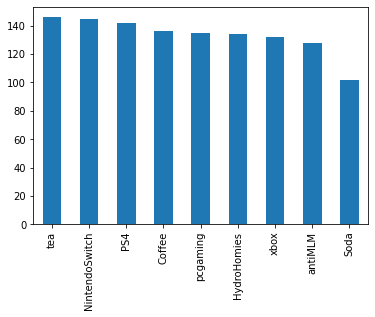

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

train_frame = pd.DataFrame(train_data)
validation_frame = pd.DataFrame(validation_data)
test_frame = pd.DataFrame(test_data)

train_labels = train_frame['subreddit']
validation_labels = validation_frame['subreddit']
test_labels = test_frame['subreddit']

print(len(train_frame))
print(len(validation_frame))
print(len(test_frame))

print("Example post:")
print(test_frame.iloc[13])

train_frame['subreddit'].value_counts().plot(kind='bar')

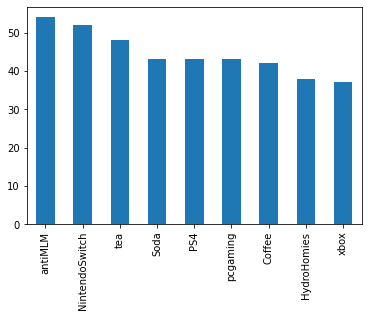

In [5]:
validation_frame['subreddit'].value_counts().plot(kind='bar')

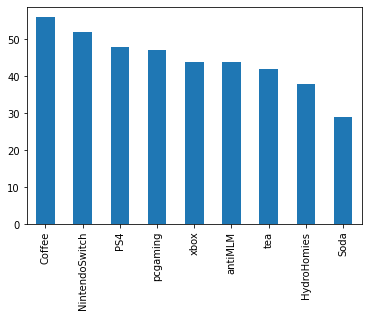

In [6]:
test_frame['subreddit'].value_counts().plot(kind='bar')

### Q1b:

In [7]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

def text_pipeline_spacy(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_stop and not t.is_punct and not t.is_space:
            tokens.append(t.lemma_.lower())
    return tokens

In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

def evaluation_summary(description, true_labels, predictions):
  print("Evaluation for: " + description)
  print(classification_report(true_labels, predictions,  digits=3, zero_division=0))
  print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions))

In [9]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

# Get features for One-hot
one_hot_vectorizer = CountVectorizer(tokenizer=text_pipeline_spacy, binary=True)
one_hot_vectorizer.fit(train_frame['body'].tolist())
train_features = one_hot_vectorizer.transform(train_frame['body'])
validation_features = one_hot_vectorizer.transform(validation_frame['body'])
test_features = one_hot_vectorizer.transform(test_frame['body'])

# Get features for TF-IDF
tfidf = TfidfVectorizer()
tfidf.fit(train_frame['body'].tolist())
train_features_tfidf = tfidf.transform(train_frame['body'])
validation_features_tfidf = tfidf.transform(validation_frame['body'])
test_features_tfidf = tfidf.transform(test_frame['body'])

# Dummy Majority
dumb = DummyClassifier(strategy='most_frequent')
dumb.fit(train_features, train_labels)
print(dumb.score(validation_features, validation_labels))
dumb_validation_predicted_labels = dumb.predict(validation_features)
evaluation_summary("Dummy majority", validation_labels, dumb_validation_predicted_labels)
dumb_test = dumb.predict(test_features)
evaluation_summary("Dummy MF test", test_labels, dumb_test)

# Dummy prior
dumber = DummyClassifier(strategy='stratified')
dumber.fit(train_features, train_labels)
print(dumber.score(validation_features, validation_labels))
dumber_validation_predicted_labels = dumber.predict(validation_features)
evaluation_summary("Dummy prior", validation_labels, dumber_validation_predicted_labels)
dumber_test = dumber.predict(test_features)
evaluation_summary("Dummy prior test", test_labels, dumber_test)

# Logistic Regression with One-hot
lr_1h = LogisticRegression(solver='saga')
lr_model_1h = lr_1h.fit(train_features, train_labels)
print(lr_model_1h.score(validation_features, validation_labels))
lr_predicted_labels_1h = lr_model_1h.predict(test_features)
evaluation_summary("LR (One-Hot)", test_labels, lr_predicted_labels_1h)
lr1h_test = lr_model_1h.predict(test_features)
evaluation_summary("LR 1H test", test_labels, lr1h_test)


# Logistic Regression with TF-IDF
lr_tfidf = LogisticRegression()
lr_model_tfidf = lr_tfidf.fit(train_features_tfidf, train_labels)
print(lr_model_tfidf.score(validation_features_tfidf, validation_labels))
lr_predicted_labels_tfidf = lr_model_tfidf.predict(validation_features_tfidf)
evaluation_summary("LR (TF-IDF)", validation_labels, lr_predicted_labels_tfidf)
lrtfidf_test = lr_model_tfidf.predict(test_features_tfidf)
evaluation_summary("LR TF-IDF test", test_labels, lrtfidf_test)


# SVC
svc = SVC(kernel='rbf')
svc_model = svc.fit(train_features, train_labels)
print(svc_model.score(validation_features, validation_labels))
svc_predicted_labels = svc_model.predict(validation_features)
evaluation_summary("SVC", validation_labels, svc_predicted_labels)
svc_test = svc_model.predict(test_features)
evaluation_summary("SVC test", test_labels, svc_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


0.12
Evaluation for: Dummy majority
                precision    recall  f1-score   support

        Coffee      0.000     0.000     0.000        42
   HydroHomies      0.000     0.000     0.000        38
NintendoSwitch      0.000     0.000     0.000        52
           PS4      0.000     0.000     0.000        43
          Soda      0.000     0.000     0.000        43
       antiMLM      0.000     0.000     0.000        54
      pcgaming      0.000     0.000     0.000        43
           tea      0.120     1.000     0.214        48
          xbox      0.000     0.000     0.000        37

      accuracy                          0.120       400
     macro avg      0.013     0.111     0.024       400
  weighted avg      0.014     0.120     0.026       400


Confusion matrix:
 [[ 0  0  0  0  0  0  0 42  0]
 [ 0  0  0  0  0  0  0 38  0]
 [ 0  0  0  0  0  0  0 52  0]
 [ 0  0  0  0  0  0  0 43  0]
 [ 0  0  0  0  0  0  0 43  0]
 [ 0  0  0  0  0  0  0 54  0]
 [ 0  0  0  0  0  0  0 43  0]
 [ 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


0.7625
Evaluation for: LR (One-Hot)
                precision    recall  f1-score   support

        Coffee      0.806     0.893     0.847        56
   HydroHomies      0.829     0.895     0.861        38
NintendoSwitch      0.818     0.692     0.750        52
           PS4      0.600     0.688     0.641        48
          Soda      0.774     0.828     0.800        29
       antiMLM      0.868     0.750     0.805        44
      pcgaming      0.659     0.574     0.614        47
           tea      0.860     0.881     0.871        42
          xbox      0.733     0.750     0.742        44

      accuracy                          0.767       400
     macro avg      0.772     0.772     0.770       400
  weighted avg      0.770     0.767     0.766       400


Confusion matrix:
 [[50  0  0  1  2  0  1  2  0]
 [ 0 34  0  1  1  1  0  1  0]
 [ 3  0 36  3  0  0  5  0  5]
 [ 1  0  3 33  1  0  6  0  4]
 [ 1  2  0  1 24  0  0  1  0]
 [ 3  3  0  2  1 33  0  2  0]
 [ 0  2  4  9  0  2 27  0  3]
 [ 

### Q1c:

In [46]:
# My own: Linear Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='log', alpha=1e-3, max_iter=100)
sgd_model = sgd.fit(train_features, train_labels)
sgd_predicted_labels = sgd_model.predict(test_features)
evaluation_summary("SGD Test", test_labels, sgd_predicted_labels)

Evaluation for: SGD Test
                precision    recall  f1-score   support

        Coffee      0.909     0.893     0.901        56
   HydroHomies      0.750     0.947     0.837        38
NintendoSwitch      0.809     0.731     0.768        52
           PS4      0.648     0.729     0.686        48
          Soda      0.767     0.793     0.780        29
       antiMLM      0.872     0.773     0.819        44
      pcgaming      0.591     0.553     0.571        47
           tea      0.864     0.905     0.884        42
          xbox      0.846     0.750     0.795        44

      accuracy                          0.782       400
     macro avg      0.784     0.786     0.782       400
  weighted avg      0.786     0.782     0.782       400


Confusion matrix:
 [[50  1  0  0  2  0  1  2  0]
 [ 0 36  0  0  0  0  1  1  0]
 [ 2  0 38  2  0  1  5  1  3]
 [ 0  0  3 35  1  1  7  0  1]
 [ 0  4  0  1 23  0  0  1  0]
 [ 0  4  0  3  2 34  0  1  0]
 [ 0  3  6  8  1  1 26  0  2]
 [ 2  0  0  0 

## Q2:

### Q2a:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.    """

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=text_pipeline_spacy)),
              ('lr', LogisticRegression())
              ])

# pipe.fit(train_frame, train_labels)
# evaluation_summary("LR", validation_labels, pipe.predict(validation_frame))
# evaluation_summary("LR", test_labels, pipe.predict(test_frame))

params = {
   'tfidf__sublinear_tf': (False, True), # Single: True (0.80)
   'tfidf__max_features': (None, 500, 1000, 5000, 10_000, 50_000), # Single: None (0.742)
   'lr__C': (10e-3, 10e-2, 10e-1, 1, 10, 10e2, 10e3, 10e4, 10e5) # Single: 1000000.0 (0.753)
}

grid_search = GridSearchCV(pipe, param_grid=params, n_jobs=1, verbose=1, scoring='f1_weighted', cv=3)
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipe.steps])
print("parameters:")
print(params)
grid_search.fit(train_frame, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

evaluation_summary("test", test_labels, grid_search.predict(test_frame))

Performing grid search...
pipeline: ['selector', 'tfidf', 'lr']
parameters:
{'tfidf__sublinear_tf': (False, True), 'tfidf__max_features': (None, 500, 1000, 5000, 10000, 50000), 'lr__C': (0.01, 0.1, 1.0, 1, 10, 1000.0, 10000.0, 100000.0, 1000000.0)}
Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Best score: 0.764
Best parameters set:
	lr__C: 1.0
	tfidf__max_features: None
	tfidf__sublinear_tf: True
Evaluation for: test
                precision    recall  f1-score   support

        Coffee      0.964     0.946     0.955        56
   HydroHomies      0.944     0.895     0.919        38
NintendoSwitch      0.768     0.827     0.796        52
           PS4      0.596     0.708     0.648        48
          Soda      0.929     0.897     0.912        29
       antiMLM      0.750     0.818     0.783        44
      pcgaming      0.610     0.532     0.568        47
           tea      0.929     0.929     0.929        42
          xbox      0.838     0.705     0.765        44

      accuracy                          0.802       400
     macro avg      0.814     0.806     0.808       400
  weighted avg      0.807     0.802     0.803       400


Confusion matrix:
 [[53  0  0  0  1  0  1  1  0]
 [ 0 34  0  1  0  2  1  0  0]
 [ 0  0 43  3  0  2  3  0  1]
 [ 0  0  6 34  0  1  5  0  2]
 [ 

In [ ]:
from sklearn.pipeline import Pipeline

# Base
pipe_base = Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=text_pipeline_spacy)),
              ('lr', LogisticRegression())
              ])

pipe_base.fit(train_frame, train_labels)
evaluation_summary("Base", test_labels, pipe_base.predict(test_frame))

# Manual input:
pipe_imp = Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=text_pipeline_spacy, 
                                        max_features=None, 
                                        sublinear_tf=True
                                        )),
              ('lr', LogisticRegression(
                  C=1_000_000,
                  solver='saga'
                  ))
              ])

pipe_imp.fit(train_frame, train_labels)
#evaluation_summary("validation", validation_labels, pipe.predict(validation_frame))
evaluation_summary("Improved?", test_labels, pipe_imp.predict(test_frame))
# Base: 0.799
# Best parameters set: 0.785 ???? with GridSearchCV
	# lr__C: 1_000_000.0
	# tfidf__max_features: None
	# tfidf__sublinear_tf: True
# By myself:
  # lr__C: 1 (default) (0.799)
  # tfidf__max_features: max?
  # sublinear__tf: True (0.803)

Evaluation for: Base
                precision    recall  f1-score   support

        Coffee      0.963     0.929     0.945        56
   HydroHomies      0.943     0.868     0.904        38
NintendoSwitch      0.778     0.808     0.792        52
           PS4      0.611     0.688     0.647        48
          Soda      0.926     0.862     0.893        29
       antiMLM      0.698     0.841     0.763        44
      pcgaming      0.628     0.574     0.600        47
           tea      0.929     0.929     0.929        42
          xbox      0.816     0.705     0.756        44

      accuracy                          0.797       400
     macro avg      0.810     0.800     0.803       400
  weighted avg      0.804     0.797     0.799       400


Confusion matrix:
 [[52  1  0  0  1  1  0  1  0]
 [ 0 33  0  0  0  3  2  0  0]
 [ 0  0 42  4  0  2  3  0  1]
 [ 0  0  6 33  0  1  5  0  3]
 [ 1  0  0  1 25  1  0  1  0]
 [ 1  1  0  1  0 37  2  1  1]
 [ 0  0  5  8  0  5 27  0  2]
 [ 0  0  0  1  1  

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


### Q2b:

In [ ]:
def labelled_evaluation_summary(description, true_labels, predictions):
  print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions, labels=test_frame['subreddit']))

0 Coffee Coffee 
1 NintendoSwitch NintendoSwitch 
2 xbox PS4 -----------
3 tea tea 
4 antiMLM antiMLM 
5 tea tea 
6 antiMLM antiMLM 
7 Coffee Coffee 
8 pcgaming PS4 -----------
9 Coffee Coffee 
10 pcgaming pcgaming 
11 NintendoSwitch NintendoSwitch 
12 pcgaming pcgaming 
13 PS4 pcgaming -----------
14 Coffee Coffee 
15 PS4 NintendoSwitch -----------
16 pcgaming NintendoSwitch -----------
17 PS4 NintendoSwitch -----------
18 antiMLM antiMLM 
19 HydroHomies HydroHomies 
20 antiMLM antiMLM 
21 HydroHomies HydroHomies 
22 xbox xbox 
23 tea tea 
24 xbox xbox 
25 NintendoSwitch NintendoSwitch 
26 Coffee Coffee 
27 NintendoSwitch NintendoSwitch 
28 Coffee Coffee 
29 HydroHomies HydroHomies 
30 antiMLM antiMLM 
31 tea tea 
32 Coffee Coffee 
33 Coffee Coffee 
34 xbox xbox 
35 tea tea 
36 pcgaming Soda -----------
37 NintendoSwitch NintendoSwitch 
38 antiMLM Coffee -----------
39 antiMLM antiMLM 
40 tea tea 
41 PS4 PS4 
42 NintendoSwitch NintendoSwitch 
43 PS4 PS4 
44 Coffee Coffee 
45 PS4 PS4 


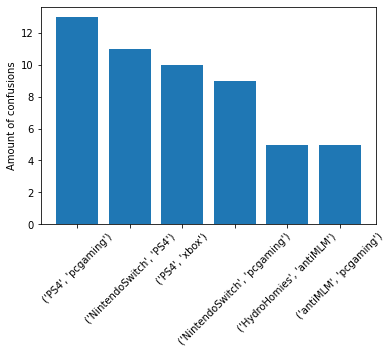

In [ ]:
from collections import Counter

#print(test_labels)
predicted_imp = pipe_imp.predict(test_frame)
#print(predicted)
confusions = Counter()
conf = {}
for i in range(len(test_labels)):
  t_label = test_labels[i]
  p_label = predicted_imp[i]
  same = p_label == t_label
  print(i, t_label, p_label, '' if same else '-----------')
  #confusions.update(sorted((t_label, p_label)))
  pair = tuple(sorted(tuple((t_label, p_label,))))
  #print(pair)
  if not same:
    conf[pair] = conf.get(pair, 0) + 1

print(test_frame.iloc[13])
print(confusions)
print(conf)
items = 6
#plt.bar(zip(conf.items()))
#conf = sorted(conf, key=lambda p: conf[p])
sorted_conf = {k: v for k, v in sorted(conf.items(), key=lambda item: item[1], reverse=True)}
plt.bar(range(items), list(sorted_conf.values())[:items], align='center')
plt.xticks(range(items), list(sorted_conf.keys())[:items], rotation = 45)
plt.ylabel("Amount of confusions")

labelled_evaluation_summary("test", test_labels, predicted_imp)

## Q3:

### Q3a:

In [ ]:
def experimental_tokenizer(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_stop and not t.is_punct and not t.is_space:
            tokens.append(t.lemma_.lower())
    return tokens

In [ ]:
from sklearn.pipeline import FeatureUnion

fu_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(tokenizer=experimental_tokenizer, 
                                        max_features=None, 
                                        sublinear_tf=True)), 
              ])),
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tfidf', TfidfVectorizer(tokenizer=experimental_tokenizer,
                                        max_features=None, 
                                        sublinear_tf=True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tfidf', TfidfVectorizer(tokenizer=experimental_tokenizer,
                                        max_features=None, 
                                        sublinear_tf=True)), 
              ])),
        ], 
        transformer_weights={'body': 0.3, 'title': 0.3, 'author': 0.4})
        )
    ])

### Q3b:

In [ ]:
fu_pipeline.fit(train_frame)
fu_train_features = fu_pipeline.transform(train_frame)
fu_validation_features = fu_pipeline.transform(validation_frame)
fu_test_features = fu_pipeline.transform(test_frame)

lr = LogisticRegression(C=1_000_000, solver='saga')
combined_model = lr.fit(fu_train_features, train_labels)
#combined_model = combined_model.fit(fu_validation_features, validation_labels)

predicted = combined_model.predict(fu_test_features)

evaluation_summary("LR TFIDF Multiple Features", test_labels, predicted)
# Results:

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Evaluation for: LR TFIDF Multiple Features
                precision    recall  f1-score   support

        Coffee      1.000     0.946     0.972        56
   HydroHomies      0.917     0.868     0.892        38
NintendoSwitch      0.742     0.885     0.807        52
           PS4      0.660     0.688     0.673        48
          Soda      0.848     0.966     0.903        29
       antiMLM      0.833     0.909     0.870        44
      pcgaming      0.744     0.617     0.674        47
           tea      0.975     0.929     0.951        42
          xbox      0.846     0.750     0.795        44

      accuracy                          0.835       400
     macro avg      0.841     0.840     0.838       400
  weighted avg      0.839     0.835     0.834       400


Confusion matrix:
 [[53  0  0  0  2  0  0  0  1]
 [ 0 33  1  1  2  1  0  0  0]
 [ 0  0 46  4  0  0  1  0  1]
 [ 0  0  5 33  0  1  6  0  3]
 [ 0  0  0  1 28  0  0  0  0]
 [ 0  1  0  0  0 40  2  1  0]
 [ 0  1  8  5  0  3 29  0 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[[53  0  0  0  2  0  0  0  1]
 [ 0 33  1  1  2  1  0  0  0]
 [ 0  0 46  4  0  0  1  0  1]
 [ 0  0  5 33  0  1  6  0  3]
 [ 0  0  0  1 28  0  0  0  0]
 [ 0  1  0  0  0 40  2  1  0]
 [ 0  1  8  5  0  3 29  0  1]
 [ 0  0  0  1  1  1  0 39  0]
 [ 0  1  2  5  0  2  1  0 33]]


[Text(0, 0.5, 'Actual Subreddits'),
 Text(0.5, 0, 'Predicted Subreddits'),
 Text(0.5, 1.0, 'Confusion Matrix')]

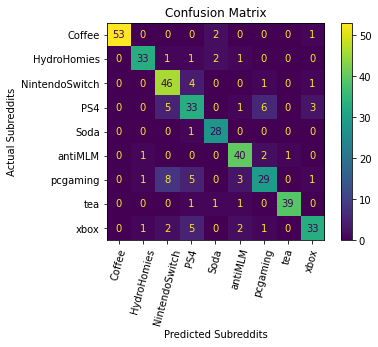

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels, predicted)
## Print the Confusion Matrix.
print(cm)
## Create the Confusion Matrix Display Object(cmd_obj). Note the 
## alphabetical sorting order of the labels.
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['Coffee', 'HydroHomies', 
                                                     'NintendoSwitch', 'PS4', 
                                                     'Soda', 'antiMLM', 
                                                     'pcgaming', 'tea', 'xbox'])
## The plot() function has to be called for the sklearn visualization
## code to do its work and the Axes object to be created.
cmd_obj.plot(xticks_rotation=75)
## Use the Axes attribute 'ax_' to get to the underlying Axes object.
## The Axes object controls the labels for the X and the Y axes. It
## also controls the title.
cmd_obj.ax_.set(
                title='Confusion Matrix', 
                xlabel='Predicted Subreddits', 
                ylabel='Actual Subreddits',
                )

### Q3c:

0 Coffee Coffee 
1 NintendoSwitch NintendoSwitch 
2 xbox xbox 
3 tea PS4 -----------
4 antiMLM antiMLM 
5 tea tea 
6 antiMLM antiMLM 
7 Coffee Coffee 
8 pcgaming pcgaming 
9 Coffee Coffee 
10 pcgaming pcgaming 
11 NintendoSwitch NintendoSwitch 
12 pcgaming HydroHomies -----------
13 PS4 NintendoSwitch -----------
14 Coffee Coffee 
15 PS4 NintendoSwitch -----------
16 pcgaming NintendoSwitch -----------
17 PS4 PS4 
18 antiMLM antiMLM 
19 HydroHomies HydroHomies 
20 antiMLM antiMLM 
21 HydroHomies HydroHomies 
22 xbox xbox 
23 tea tea 
24 xbox xbox 
25 NintendoSwitch NintendoSwitch 
26 Coffee Coffee 
27 NintendoSwitch NintendoSwitch 
28 Coffee Coffee 
29 HydroHomies HydroHomies 
30 antiMLM antiMLM 
31 tea tea 
32 Coffee Coffee 
33 Coffee Coffee 
34 xbox xbox 
35 tea tea 
36 pcgaming pcgaming 
37 NintendoSwitch NintendoSwitch 
38 antiMLM antiMLM 
39 antiMLM antiMLM 
40 tea tea 
41 PS4 PS4 
42 NintendoSwitch NintendoSwitch 
43 PS4 PS4 
44 Coffee Coffee 
45 PS4 PS4 
46 HydroHomies HydroHomi

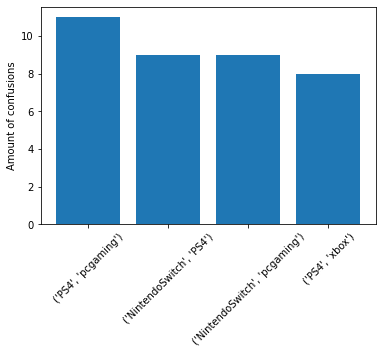

In [ ]:
from collections import Counter

confusions = Counter()
conf = {}
for i in range(len(test_labels)):
  t_label = test_labels[i]
  p_label = predicted[i]
  same = p_label == t_label
  print(i, t_label, p_label, '' if same else '-----------')
  #confusions.update(sorted((t_label, p_label)))
  pair = tuple(sorted(tuple((t_label, p_label,))))
  #print(pair)
  if not same:
    conf[pair] = conf.get(pair, 0) + 1

print(test_frame.iloc[13])
print(confusions)
print(conf)
items = 4
#plt.bar(zip(conf.items()))
#conf = sorted(conf, key=lambda p: conf[p])
sorted_conf = {k: v for k, v in sorted(conf.items(), key=lambda item: item[1], reverse=True)}
plt.bar(range(items), list(sorted_conf.values())[:items], align='center')
plt.xticks(range(items), list(sorted_conf.keys())[:items], rotation = 45)
plt.ylabel("Amount of confusions")

labelled_evaluation_summary("test", test_labels, predicted)